In [1]:
# https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification
"""
The dataset contains photographs of three legume leaf lesion states,
including 1034 images in the training set and 133 images in the calibration set, with a data size of 155 MB.
The following leaf lesion states are supported to be recognized: healthy, angular_leaf_spot, and bean_rust.
""";

In [2]:
#!/bin/bash
!curl -L -o ./bean-leaf-lesions-classification.zip \
    https://www.kaggle.com/api/v1/datasets/download/marquis03/bean-leaf-lesions-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  154M  100  154M    0     0  16.7M      0  0:00:09  0:00:09 --:--:-- 21.8M


In [3]:
!unzip -q bean-leaf-lesions-classification.zip -d bean-leaf-lesions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
df_train = pd.read_csv('./bean-leaf-lesions/train.csv')
print(df_train.columns)
df_train.columns = ['image_path', 'category']
df_train.head()

Index(['image:FILE', 'category'], dtype='object')


,image_path,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [6]:
df_train['category'].value_counts()

,count
category,
2,348
1,345
0,341


In [7]:
df_train.shape

(1034, 2)

In [8]:
df_test = pd.read_csv('./bean-leaf-lesions/val.csv')
df_test.shape

(133, 2)

## Logging

In [9]:
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.0 MB/s eta 0:00:00


In [10]:
# src/logger.py
from loguru import logger
import os

def setup_logger(log_dir="outputs/logs", filename="train.log"):
    os.makedirs(log_dir, exist_ok=True)
    logger.add(os.path.join(log_dir, filename), rotation="1 MB", retention="10 days")
    return logger


## Data Preprocessing & Train-Validation Split

In [11]:
# src/data_loader.py

import pandas as pd
from sklearn.model_selection import train_test_split
#from src.logger import setup_logger

logger = setup_logger()

def load_and_split_data(csv_path, val_size=0.2, random_state=42, save_split=False):
    logger.info(f"Loading dataset from {csv_path}")
    df = pd.read_csv(csv_path)
    df.columns = ['image_path', 'category']
    logger.info(f"Total samples: {len(df)}")

    # Stratify ensures class distribution remains balanced
    train_df, val_df = train_test_split(
        df,
        test_size=val_size,
        stratify=df['category'],
        random_state=random_state
    )

    logger.info(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

    if save_split:
        train_df.to_csv("data/train_split.csv", index=False)
        val_df.to_csv("data/val_split.csv", index=False)
        logger.info("Saved train/val splits to disk.")

    return train_df, val_df


In [12]:
#from src.data_loader import load_and_split_data
!mkdir -p data
train_csv_path = "./bean-leaf-lesions/train.csv"
train_df, val_df = load_and_split_data(train_csv_path, val_size=0.2, save_split=True)


2025-04-09 19:24:51.966 | INFO     | __main__:load_and_split_data:10 - Loading dataset from ./bean-leaf-lesions/train.csv
2025-04-09 19:24:51.971 | INFO     | __main__:load_and_split_data:13 - Total samples: 1034
2025-04-09 19:24:51.978 | INFO     | __main__:load_and_split_data:23 - Training samples: 827, Validation samples: 207
2025-04-09 19:24:51.989 | INFO     | __main__:load_and_split_data:28 - Saved train/val splits to disk.


## Custom PyTorch Dataset & Dataloaders

In [13]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class BeanLeafDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.loc[idx, "image_path"])
        label = int(self.dataframe.loc[idx, "category"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


def get_dataloaders(train_df, val_df, root_dir, transform, batch_size=32, num_workers=2):
    train_dataset = BeanLeafDataset(train_df, root_dir, transform=transform)
    val_dataset = BeanLeafDataset(val_df, root_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


def get_test_loader(test_csv_path, root_dir, transform, batch_size=32, num_workers=2):
    import pandas as pd
    df = pd.read_csv(test_csv_path)
    df.columns = ['image_path', 'category']
    dataset = BeanLeafDataset(df, root_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return loader


In [14]:
# # from src.data_loader import load_and_split_data, get_dataloaders
# from torchvision import transforms

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# train_loader, val_loader = get_dataloaders(train_df, val_df,
#                                            root_dir="./bean-leaf-lesions/data/train",
#                                            transform=transform)


## Modular Transforms Setup

In [15]:
from torchvision import transforms

def get_transforms(mode="train"):
    if mode == "train":
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    elif mode in ["val", "test"]:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError(f"Unknown mode {mode}, use 'train', 'val', or 'test'")


In [16]:
# from src.transforms import get_transforms
# from src.data_loader import load_and_split_data, get_dataloaders

train_transform = get_transforms("train")
val_transform = get_transforms("val")

train_loader, val_loader = get_dataloaders(
    train_df, val_df, root_dir="./bean-leaf-lesions",
    transform=train_transform, batch_size=32
)


## Transfer Learning Model Setup

In [17]:
import torch.nn as nn
from torchvision.models import (
    resnet18, ResNet18_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights
)

def get_model(model_name="resnet18", num_classes=3, freeze_features=True):
    if model_name == "resnet18":
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        in_features = model.fc.in_features

        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False

        model.fc = nn.Linear(in_features, num_classes)

    elif model_name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
        in_features = model.classifier[1].in_features

        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False

        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif model_name == "convnext_tiny":
        weights = ConvNeXt_Tiny_Weights.DEFAULT
        model = convnext_tiny(weights=weights)
        in_features = model.classifier[2].in_features

        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False

        model.classifier[2] = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' is not supported yet.")

    return model


In [18]:
# from models.model import get_model

num_classes = 3
model = get_model(model_name="convnext_tiny", num_classes=num_classes, freeze_features=True)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 71.5MB/s]


## Training Loop

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
# from src.logger import setup_logger
import os

logger = setup_logger()

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    device,
    lr=1e-3,
    checkpoint_path="outputs/checkpoints/best_model.pth"
):
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    best_val_acc = 0.0
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = train_loss / total
        epoch_train_acc = correct / total

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        logger.info(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        logger.info(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), checkpoint_path)
            best_val_acc = val_acc
            logger.info(f"Saved new best model with acc {best_val_acc:.4f}\n")

    return model, history

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [20]:
import matplotlib.pyplot as plt

def plot_training_curves(history, save_path="outputs/training_plot.png"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.xticks(epochs)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.xticks(epochs)
    plt.ylim(0, 1)  # Set y-axis limit for accuracy from 0 to 1

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


In [21]:
# from src.train import train_model
# from src.utils import plot_training_curves

device = "cuda" if torch.cuda.is_available() else "cpu"

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    device=device
)


2025-04-09 19:25:14.801 | INFO     | __main__:train_model:35 - Epoch 1/20
2025-04-09 19:25:28.240 | INFO     | __main__:train_model:60 - Train Loss: 0.8527 | Train Acc: 0.6638
2025-04-09 19:25:28.241 | INFO     | __main__:train_model:61 - Val   Loss: 0.6982 | Val   Acc: 0.7343
2025-04-09 19:25:28.415 | INFO     | __main__:train_model:72 - Saved new best model with acc 0.7343

2025-04-09 19:25:28.417 | INFO     | __main__:train_model:35 - Epoch 2/20
2025-04-09 19:25:41.514 | INFO     | __main__:train_model:60 - Train Loss: 0.6014 | Train Acc: 0.7993
2025-04-09 19:25:41.515 | INFO     | __main__:train_model:61 - Val   Loss: 0.5876 | Val   Acc: 0.7826
2025-04-09 19:25:41.787 | INFO     | __main__:train_model:72 - Saved new best model with acc 0.7826

2025-04-09 19:25:41.789 | INFO     | __main__:train_model:35 - Epoch 3/20
2025-04-09 19:25:54.876 | INFO     | __main__:train_model:60 - Train Loss: 0.5043 | Train Acc: 0.8343
2025-04-09 19:25:54.877 | INFO     | __main__:train_model:61 - Val

In [22]:
plot_training_curves(history)


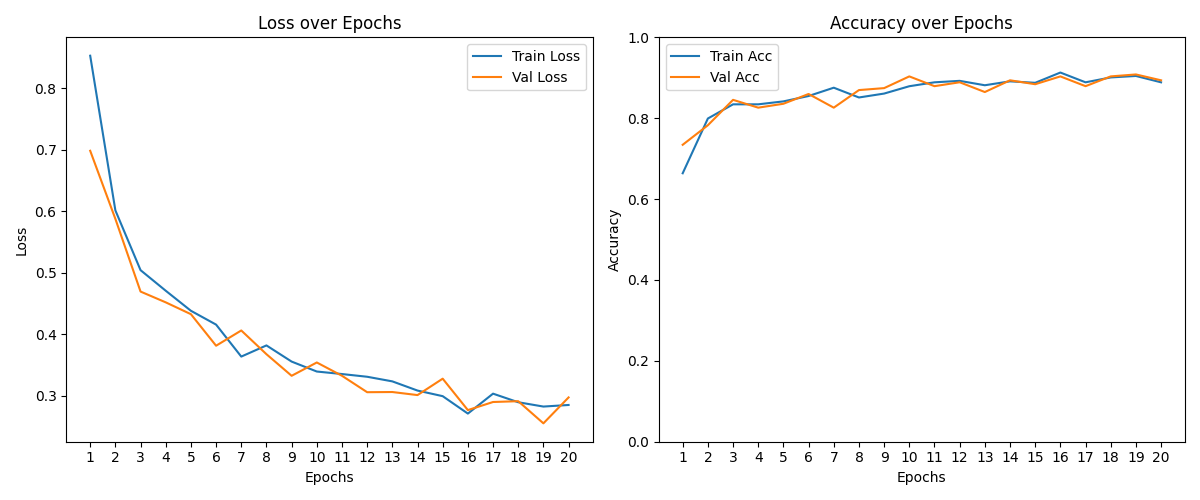

In [23]:
from IPython.display import Image

# Load and display the image
Image(filename='outputs/training_plot.png')


## Final Test Set Evaluation

In [24]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
# from src.logger import setup_logger

logger = setup_logger()

def evaluate_on_test(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Metrics
    logger.info("Classification Report:\n" + classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("outputs/test_confusion_matrix.png")
    plt.close()


In [25]:
# from src.data_loader import get_test_loader
# from src.evaluate import evaluate_on_test
# from src.transforms import get_transforms
import torch

# Load best model
model.load_state_dict(torch.load("outputs/checkpoints/best_model.pth"))
model.eval()

# Load test set
test_loader = get_test_loader(
    test_csv_path="./bean-leaf-lesions/val.csv",
    root_dir="./bean-leaf-lesions",
    transform=get_transforms("test"),
    batch_size=32
)

# Evaluate
class_names = ["healthy", "angular_leaf_spot", "bean_rust"]
evaluate_on_test(model, test_loader, device=device, class_names=class_names)


2025-04-09 19:29:45.720 | INFO     | __main__:evaluate_on_test:24 - Classification Report:
                   precision    recall  f1-score   support

          healthy       0.95      0.95      0.95        44
angular_leaf_spot       0.97      0.80      0.88        44
        bean_rust       0.81      0.96      0.88        45

         accuracy                           0.90       133
        macro avg       0.91      0.90      0.90       133
     weighted avg       0.91      0.90      0.90       133



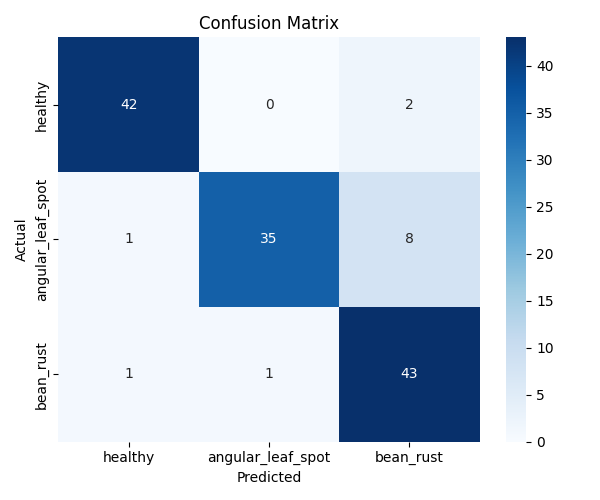

In [26]:
from IPython.display import Image

# Load and display the image
Image(filename='outputs/test_confusion_matrix.png')


## Inference

In [27]:
import torch
from PIL import Image
from torchvision import transforms
import os

# from src.transforms import get_transforms
# from models.model import get_model

def load_model(checkpoint_path, model_name, num_classes=3, device="cpu"):
    model = get_model(model_name=model_name, num_classes=num_classes, freeze_features=False)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, class_names, device="cpu"):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # [1, C, H, W]

    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    return class_names[pred_idx], probs.squeeze().tolist()


In [28]:
# from src.inference import load_model, predict_image
# from src.transforms import get_transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model("outputs/checkpoints/best_model.pth", model_name="convnext_tiny", device=device)

image_path = "./bean-leaf-lesions/val/healthy/healthy_val.0.jpg"  # use your own test image here
transform = get_transforms("test")
class_names = ["healthy", "angular_leaf_spot", "bean_rust"]

label, probs = predict_image(image_path, model, transform, class_names, device=device)

print(f"Prediction: {label}")
print("Class Probabilities:")
for cls, p in zip(class_names, probs):
    print(f"{cls}: {p:.4f}")


Prediction: bean_rust
Class Probabilities:
healthy: 0.1351
angular_leaf_spot: 0.0606
bean_rust: 0.8043


Prediction: bean_rust
Class Probabilities (sorted):
bean_rust: 80.43%
healthy: 13.51%
angular_leaf_spot: 6.06%


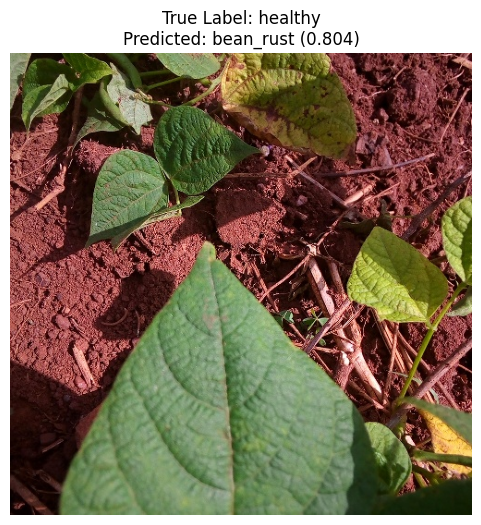

In [29]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming the model, transform, etc. are already defined as in your example
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model("outputs/checkpoints/best_model.pth", model_name="convnext_tiny", device=device)

# Give the test image & the actual label for the image
image_path = "./bean-leaf-lesions/val/healthy/healthy_val.0.jpg"
true_label = "healthy"  # Replace with the actual true label for the above image

transform = get_transforms("test")
class_names = ["healthy", "angular_leaf_spot", "bean_rust"]

# Make prediction
label, probs = predict_image(image_path, model, transform, class_names, device=device)

# 1. Sort the predicted probabilities (highest to lowest)
sorted_probs = sorted(zip(class_names, probs), key=lambda x: x[1], reverse=True)

print(f"Prediction: {label}")
print("Class Probabilities (sorted):")
for cls, p in sorted_probs:
    print(f"{cls}: {p*100:.2f}%")

# 2. Plot the image with true label and predicted label in the title
image = Image.open(image_path)
predicted_label = sorted_probs[0][0]  # The class with the highest probability
highest_prob = sorted_probs[0][1]  # The highest probability

plt.figure(figsize=(6, 6))
plt.imshow(np.array(image))
plt.axis('off')  # Hide axis
plt.title(f"True Label: {true_label}\nPredicted: {predicted_label} ({highest_prob:.3f})")
plt.show()
